In [1]:
import sys
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

import atmos as atm

# Import local modules
sys.path.append('src')
import plots

%matplotlib inline

## User Inputs and Setup

In [2]:
# Data directories and files
homedir = os.path.expanduser('~')
datadir_root = homedir + '/datastore/'
datadir_merra = datadir_root + 'merra2/figure_data/'
savedir = 'figures/'

ind_nm = 'onset'
#ind_nm = 'retreat'
yearstr = '1980-2015'

# Adjust parameters for plotting either onset or retreat index
suffix = yearstr + '.nc'
if ind_nm == 'retreat':
    npre, npost = 270, 100
    suffix = yearstr + '_retreat.nc'
else:
    npre, npost =  120, 200
    suffix = yearstr + '.nc'

# Data files
filestr = datadir_merra + 'merra2_%s_' + suffix
datafiles = {}
datafiles['index'] = datadir_merra + 'merra2_index_CHP_MFC_' + suffix
datafiles['mld'] = datadir_root + 'mld/ifremer_mld_DT02_c1m_reg2.0.nc'
for nm in ['latp', 'hov', 'latlon', 'tseries', 'ebudget', 'ubudget', 'psi_comp']:
    datafiles[nm] = filestr % nm
if ind_nm == 'retreat':
    datafiles['gpcp'] = datadir_merra + 'gpcp_dailyrel_retreat_1997-2015.nc'
else:
    datafiles['gpcp'] = datadir_merra + 'gpcp_dailyrel_1997-2015.nc'
datafiles

{'ebudget': 'C:\\Users\\jenfl/datastore/merra2/figure_data/merra2_ebudget_1980-2015.nc',
 'gpcp': 'C:\\Users\\jenfl/datastore/merra2/figure_data/gpcp_dailyrel_1997-2015.nc',
 'hov': 'C:\\Users\\jenfl/datastore/merra2/figure_data/merra2_hov_1980-2015.nc',
 'index': 'C:\\Users\\jenfl/datastore/merra2/figure_data/merra2_index_CHP_MFC_1980-2015.nc',
 'latlon': 'C:\\Users\\jenfl/datastore/merra2/figure_data/merra2_latlon_1980-2015.nc',
 'latp': 'C:\\Users\\jenfl/datastore/merra2/figure_data/merra2_latp_1980-2015.nc',
 'mld': 'C:\\Users\\jenfl/datastore/mld/ifremer_mld_DT02_c1m_reg2.0.nc',
 'psi_comp': 'C:\\Users\\jenfl/datastore/merra2/figure_data/merra2_psi_comp_1980-2015.nc',
 'tseries': 'C:\\Users\\jenfl/datastore/merra2/figure_data/merra2_tseries_1980-2015.nc',
 'ubudget': 'C:\\Users\\jenfl/datastore/merra2/figure_data/merra2_ubudget_1980-2015.nc'}

In [3]:
# SASM domain
lon1, lon2 = 60, 100
lat1, lat2 = 10, 30

# Pressure level for momentum budget
plev_ubudget = 200

# Latitude range to average for equatorial energy transport
eqlat1, eqlat2 = -5, 5

In [4]:
# Flag to toggle on/off saving figures to files
save_figs = True

# Figure formatting
style_file = 'mpl-styles/article.mplstyle'

figwidth = 7.48
plt.style.use(style_file)
fontsize = mpl.rcParams['font.size']
labelsize = fontsize + 3
dashes = [6, 2]

## Load Data

In [5]:
# Read data from netcdf files
data = {}
for nm in datafiles:
    if nm == 'mld':
        decode_times = False
    else:
        decode_times = True
    print('Loading ' + datafiles[nm])
    with xr.open_dataset(datafiles[nm], decode_times=decode_times) as ds:
        data[nm] = ds.load()

Loading C:\Users\jenfl/datastore/merra2/figure_data/merra2_latlon_1980-2015.nc
Loading C:\Users\jenfl/datastore/merra2/figure_data/merra2_index_CHP_MFC_1980-2015.nc
Loading C:\Users\jenfl/datastore/merra2/figure_data/merra2_latp_1980-2015.nc
Loading C:\Users\jenfl/datastore/mld/ifremer_mld_DT02_c1m_reg2.0.nc
Loading C:\Users\jenfl/datastore/merra2/figure_data/merra2_ubudget_1980-2015.nc
Loading C:\Users\jenfl/datastore/merra2/figure_data/gpcp_dailyrel_1997-2015.nc
Loading C:\Users\jenfl/datastore/merra2/figure_data/merra2_psi_comp_1980-2015.nc
Loading C:\Users\jenfl/datastore/merra2/figure_data/merra2_hov_1980-2015.nc
Loading C:\Users\jenfl/datastore/merra2/figure_data/merra2_ebudget_1980-2015.nc
Loading C:\Users\jenfl/datastore/merra2/figure_data/merra2_tseries_1980-2015.nc


In [6]:
# Timeseries data
tseries = data['tseries']

# Indices for monsoon onset, retreat, season length
index = data['index']
index['length'] = index['retreat'] - index['onset']

# Latitude-pressure data fields
data_latp = data['latp']

# Surface pressure
ps = data_latp['PS'] / 100

# Moist static energy budget
ebudget = data['ebudget']
ebudget_eq = atm.dim_mean(ebudget, 'lat', eqlat1, eqlat2)
ebudget_sector = atm.dim_mean(ebudget, 'lon', lon1, lon2)
ebudget_eq_sector = atm.dim_mean(ebudget_eq, 'lon', lon1, lon2)

In [7]:
# Latitude-time data fields for Hovmoller plots
# ---------------------------------------------

data_hov = {nm : data['hov'][nm] for nm in data['hov'].data_vars}
data_hov['GPCP'] = data['gpcp']['PCP_SECTOR']

# Temporary fix for missing data in THETA_E_LML
var = data_hov['THETA_E_LML']
dmin, dmax = var['dayrel'].values.min(), var['dayrel'].values.max()
if ind_nm == 'onset':
    d1, d2 = 178, 183
else:
    d1, d2 = 19, 24
var1 = var.sel(dayrel=range(dmin, d1))
var2 = var.sel(dayrel=range(d2, dmax + 1))
data_hov['THETA_E_LML'] = xr.concat((var1, var2), dim='dayrel')

# Surface moist static energy
Cp = atm.constants.Cp.values
Lv = atm.constants.Lv.values
data_hov['MSE_LML'] = (data_hov['TLML'] * Cp + data_hov['QLML'] * Lv) / 1e3
data_hov['MSE_LML'].name = 'MSE_LML'
data_hov['MSE_LML'].attrs['units'] = 'kJ kg^-1'

## Figures

### Latitude-Day Hovmoller Plots

In [8]:
xticks = range(-npre, npost + 10, 30)
if ind_nm == 'onset':
    dlist = [0, index['length'].mean(dim='year')]
    d0 = 15
else:
    dlist = [-index['length'].mean(dim='year'), 0]
    d0 = None

keys = ['GPCP', 'PSI500', 'U200', 'T200', 'THETA_E_LML']
clevs = {'GPCP' : 1, 'U200' : 5, 'V200' : 1, 'PSI500' : 5, 'T200' : 0.5,
         'THETA_E_LML' : 2.5, 'TLML' : 1, 'QLML' : 5e-4, 'U850' : 1,
         'MSE_LML' : 2}
cticks_dict = {'GPCP' : np.arange(0, 13, 2),
               'T200' : np.arange(208, 229, 4),
               'U200' : np.arange(-80, 81, 20),
               'U850' : np.arange(-20, 21, 4),
               'PSI500' : np.arange(-80, 81, 20),
               'THETA_E_LML' : np.arange(240, 361, 20),
               'MSE_LML' : np.arange(240, 361, 20)}
clim_dict = {'GPCP' : (0, 10), 'U200' : (-50, 50),
             'PSI500' : (-80, 80), 'T200' : (208, 227),
             'THETA_E_LML' : (260, 350), 'U850' : (-18, 18),
             'MSE_LML' : (245, 350)}

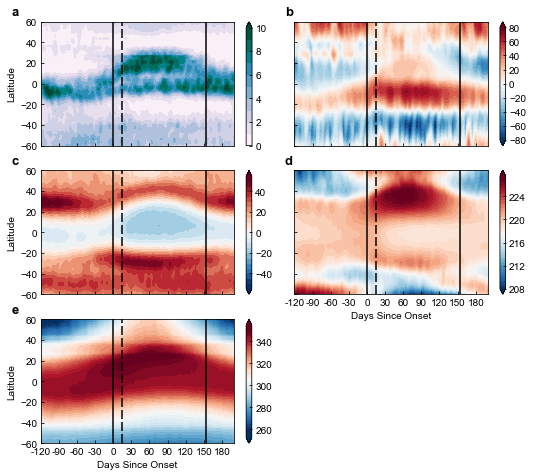

In [14]:
nrow, ncol = 3, 2
fig_kw = {'figsize' : (figwidth, 0.9 * figwidth),  'sharey' : True}
gridspec_kw = {'left' : 0.07, 'right' : 0.99, 'bottom' : 0.07, 'top' : 0.94,
               'wspace' : 0.05}
grp = atm.FigGroup(nrow, ncol, fig_kw=fig_kw, gridspec_kw=gridspec_kw)
for key in keys:
    grp.next()
    var = data_hov[key]
    clev = clevs.get(key)
    cticks = cticks_dict.get(key)
    climits = clim_dict.get(key)
    if key == 'GPCP':
        is_precip, cmap, extend = True, 'PuBuGn', 'max'
    else:
        is_precip, cmap, extend = False, 'RdBu_r', 'both'
    if grp.row == grp.nrow - 1 or key == keys[-2]:
        xlabels = True
    else:
        xlabels = False
    plots.contourf_latday(var, is_precip=is_precip, clev=clev, cticks=cticks, climits=climits,
                          grp=grp, dlist=dlist, ind_nm=ind_nm, 
                          xlabels=xlabels)
    if d0 is not None:
        plt.axvline(d0, color='k', linestyle='--', dashes=dashes)
        
if ind_nm == 'onset':
    plt.xlim(-npre, npost)
else:
    plt.xlim(-npre, 90)
labels = ['a', 'b', 'c', 'd', 'e']
x1, x2, y0 = -0.15, -0.05, 1.05
pos = [(x1, y0), (x2, y0), (x1, y0), (x2, y0), (x1, y0), (x2, y0)]
plots.add_labels(grp, labels, pos, labelsize)

# Hide axes on empty plot
ax = grp.axes[nrow - 1 , ncol - 1]
ax.axis('off')

# Save figure
if save_figs:
    plt.savefig(savedir + 'hovmoller_latday.eps')

### Moist Static Energy Budget
#### Longitude-Day Hovmoller Plots

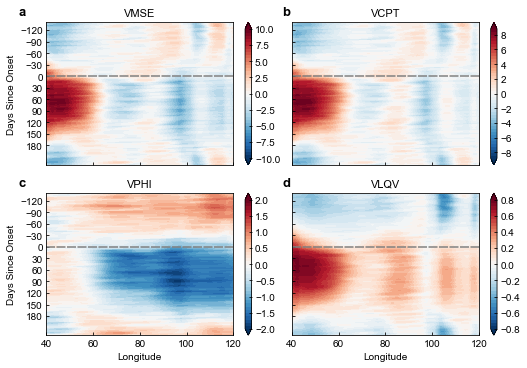

In [17]:
mse_vars = {'VMSE' : 'VH', 'VCPT' : 'VFLXCPT', 'VPHI' : 'VFLXPHI',
            'VLQV' : 'VFLXLQV'}

scale = 1e9
vmse_eq = xr.Dataset({nm : ebudget_eq[mse_vars[nm]] for nm in mse_vars})
vmse_eq = vmse_eq / scale

nrow, ncol = 2, 2
fig_kw = {'figsize' : (figwidth, 0.7 * figwidth), 'sharex' : True,
          'sharey' : True}
gridspec_kw = {'left' : 0.1, 'right' : 0.99, 'bottom' : 0.07, 'top' : 0.9,
               'wspace' : 0.05}
grp = atm.FigGroup(nrow, ncol, fig_kw=fig_kw, gridspec_kw=gridspec_kw)
lonrange = (40, 120)
for nm in ['VMSE', 'VCPT', 'VPHI', 'VLQV']:
    grp.next()
    var = atm.subset(vmse_eq[nm], {'lon' : lonrange})
    plots.contourf_londay(var, grp=grp)
    plt.title(nm, fontsize=11)
plt.gca().invert_yaxis()

labels = ['a', 'b', 'c', 'd']
x1, x2, y0 = -0.15, -0.05, 1.05
pos = [(x1, y0), (x2, y0), (x1, y0), (x2, y0)]
plots.add_labels(grp, labels, pos, labelsize)

if save_figs:
    plt.savefig(savedir + 'mse_flux_hovmoller.eps')

#### MSE Transport - Line Plots

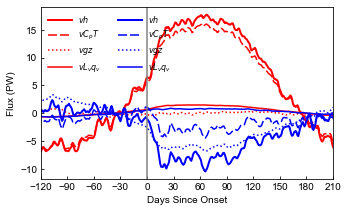

In [21]:
# Cross-equatorial flues integrated over sectors
a = atm.constants.radius_earth.values
eq_int = xr.Dataset()
lonranges = [(40, 60), (40, 100), (lon1, lon2)]
eq_int.attrs['lonranges'] = ['%d-%dE' % lonrange for lonrange in lonranges]
for lonrange in lonranges:
    lon1, lon2 = lonrange
    dist = a * np.radians(lon2 - lon1)
    for nm in vmse_eq.data_vars:
        key = nm + '_%d-%dE' % (lon1, lon2)
        eq_int[key] = atm.dim_mean(vmse_eq[nm], 'lon', lon1, lon2) * dist
# Convert to PW
eq_int = eq_int / 1e6


days = atm.get_coord(eq_int, 'dayrel')
nms = ['VMSE', 'VCPT', 'VPHI', 'VLQV']
nms_dict = {'VMSE' : r'$vh$', 'VCPT' : r'$vC_pT$', 'VPHI' : r'$vgz$', 'VLQV' : r'$vL_vq_v$'}

colors = {'40-60E' : 'r', '60-100E' : 'b'}
styles = {'VMSE' : {'linewidth' : 2}, 'VPHI' : {'linestyle' : 'dotted'},
          'VCPT' : {'linestyle' : 'dashed', 'dashes' : dashes},
          'VLQV' : {'linestyle' : 'solid'}}
lonranges = ['40-60E', '60-100E']

plt.figure(figsize=(0.7*figwidth, 0.4 * figwidth))
for lonrange in lonranges:
    for nm in nms:
        style = styles[nm]
        style['color'] = colors[lonrange]
        key = nm + '_' + lonrange
        plt.plot(days, eq_int[key], label=nms_dict[nm], **style)
plt.legend(loc='upper left', ncol=2, handlelength=3, fontsize=8)

plt.xticks(np.arange(-120, 211, 30))
plt.xlim(-120, 210)
plt.axvline(0, color='0.5')
plt.xlabel('Days Since Onset')
plt.ylabel('Flux (PW)')

if save_figs:
    plt.savefig(savedir + 'mse_flux_lineplot.eps')